In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import math
import matplotlib.pyplot as plt

In [2]:
# lire données

PREFIX = "/content/drive/MyDrive/Colab Notebooks/"

EMBEDDINGS = PREFIX+"embeddings.txt"
VOCAB = PREFIX+"vocab.txt"

POS_TWEETS = PREFIX+"twitter-datasets/train_pos_full.txt"
NEG_TWEETS = PREFIX+"twitter-datasets/train_neg_full.txt"
TEST_DATA = PREFIX+"twitter-datasets/test_data.txt"

# parse embeddings
vecs = {}
with open(EMBEDDINGS, "r") as f:
    for line in f:
        pline = line.rstrip().split(' ')
        word = pline[0]
        vecs[word] = np.array([float(x) for x in pline[1:]])

# parse vocabulary and build an index
with open(VOCAB, "r") as f:
    vocab = {x.rstrip().split(' ')[0]: i for i,x in enumerate(f)}
EMBEDDING_SIZE = len(vecs[list(vecs.keys())[0]])
embeddings = np.zeros((len(vocab), EMBEDDING_SIZE))
for w, v in vecs.items():
    if w == "<unk>":
        continue
    embeddings[vocab[w], :] = v


In [3]:
len_tweets = []
def load_from_file(filename, max_length_tweets):
    tweet_list = []
    with open(filename, "r") as f:
        for line in f:
            tweet = line.rstrip().split()
            l_tweet = len(tweet)
            tweet_list.append(tweet)
            if l_tweet > max_length_tweets:
                #print(f"{l_tweet}: {tweet}")
                max_length_tweets = len(tweet)
            len_tweets.append(l_tweet)
    return tweet_list, max_length_tweets

max_length_tweets = -1
p_tweets, max_length_tweets = load_from_file(POS_TWEETS, max_length_tweets)
n_tweets, max_length_tweets = load_from_file(NEG_TWEETS, max_length_tweets)
N = len(n_tweets) + len(p_tweets)
print(f"Loaded {N} tweets (max len {max_length_tweets})")

Loaded 2500000 tweets (max len 128)


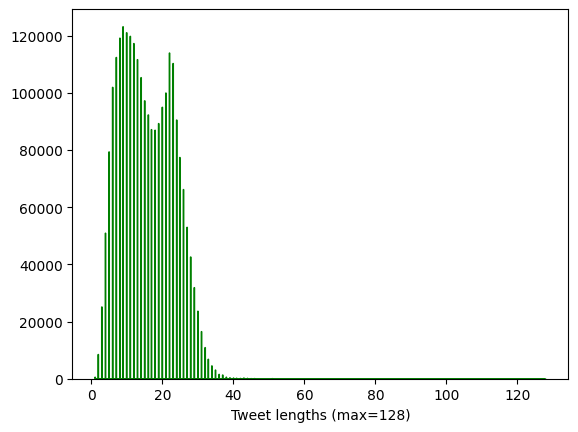

In [4]:
# We see that tweets that have a length over 40-60 are very rare.
counts, bins = np.histogram(len_tweets, bins=1000)
plt.xlabel(f"Tweet lengths (max={max_length_tweets})")
plt.stairs(counts, bins, color='g')

In [5]:
# We thus drop all of them and adjust our max tweet length to avoid memory explosion
truncated_length = 50
max_length_tweets = truncated_length
p_tweets = [t for t in p_tweets if len(t) <= truncated_length]
n_tweets = [t for t in n_tweets if len(t) <= truncated_length]
if len(p_tweets) != len(n_tweets):
    print(f"Dropping a few more tweets to equalize lengths ({len(p_tweets)} != {len(n_tweets)})")
    min_length = min(len(p_tweets), len(n_tweets))
    if len(p_tweets) == min_length:
        n_tweets = n_tweets[:min_length]
    else:
        p_tweets = p_tweets[:min_length]
old_N_tweets = N
N = (len(p_tweets) + len(n_tweets))
print(f"Dropped {old_N_tweets - N} tweets of length > {truncated_length}")
print(f"Total is now {N} tweets (+: {len(p_tweets)}, -: {len(n_tweets)})")

Dropping a few more tweets to equalize lengths (1249918 != 1249935)
Dropped 164 tweets of length > 50
Total is now 2499836 tweets (+: 1249918, -: 1249918)


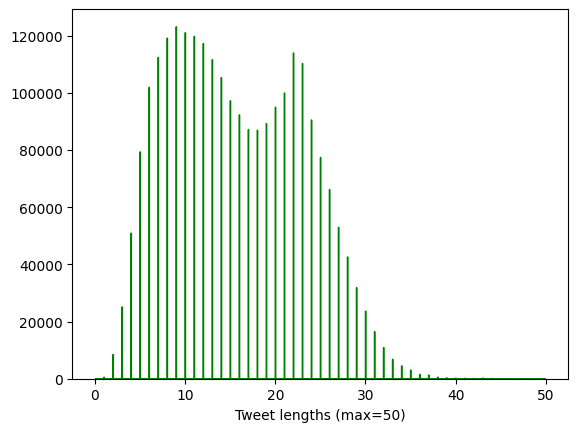

In [6]:
counts, bins = np.histogram(len_tweets, bins=1000, range=(0, truncated_length))
plt.xlabel(f"Tweet lengths (max={max_length_tweets})")
plt.stairs(counts, bins, color='g')

In [7]:
testing_tweets = []
testing_tweets_ids = []
with open(TEST_DATA, "r") as f:
    for line in f:
        parsed_line = line.rstrip().split(',')
        tweet = ','.join(parsed_line[1:]).split()
        testing_tweets.append(tweet)
        testing_tweets_ids.append(int(parsed_line[0]))


In [8]:
def modified_load_tweets(tweets_list, tensor, max_tweet_length, label=None ):
    print("Loading tweets...")
    i = 0
    tot = len(tweets_list)

    vocab_keys = set(vocab.keys())
    for tweet in tweets_list:
        if i % 5000 == 0 or i == tot:
            print(f"{i}/{tot} ({int(i/tot*100)} %)")

       # Filter out words not in the vocabulary
        tweet_filtered = [word for word in tweet if word in vocab_keys]

        # Create a tensor directly without using list comprehensions

        embeddings_list_torch = torch.FloatTensor(np.array([embeddings[vocab[word]] for word in tweet_filtered]))

        length_tweet=len(tweet_filtered)

        diff_length=max_tweet_length - length_tweet

        if length_tweet == 0:
            tweet_embeddings = torch.zeros((max_tweet_length, len(vecs[list(vecs.keys())[0]])))
        else:
           tweet_mean = torch.mean(embeddings_list_torch, axis=0)
           tweet_embeddings = torch.ones((max_tweet_length, len(vecs[list(vecs.keys())[0]])))*tweet_mean # to have all tweets of shape (#tweets, max_tweet_len, 20)
           middle = diff_length//2
           if (diff_length%2==0):
               tweet_embeddings[middle:max_tweet_length-middle,:] = embeddings_list_torch #putting them in the middle to do some kind of padding
           else:
               tweet_embeddings[middle:(max_tweet_length-(middle+1)),:] = embeddings_list_torch
        if label is not None:
            tweet_embeddings = torch.vstack((tweet_embeddings, label*torch.ones(EMBEDDING_SIZE,)))

        tensor[i] = tweet_embeddings
        i += 1
    return tensor

In [14]:
def save_train(torch_series_train, batch_n=''):
    SAVE_PREFIX = PREFIX + "batches/"
    SUFFIX = '_'+str(batch_n)+'_full.pt'

    X = torch_series_train[:,:-1]
    y = torch_series_train[:,-1]
    RANDOM_SEED = 1234

    X_flattened = X.view(X.size(0), -1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
    X_train = X_train.view(X_train.size(0), max_tot, EMBEDDING_SIZE)
    X_test = X_test.view(X_test.size(0), max_tot, EMBEDDING_SIZE)
    torch.save(X_train, SAVE_PREFIX+'X_train_cnn_new'+SUFFIX)
    torch.save(X_test, SAVE_PREFIX+'X_test_cnn_new'+SUFFIX)
    torch.save(y_train, SAVE_PREFIX+'y_train_cnn_new'+SUFFIX)
    torch.save(y_test, SAVE_PREFIX+'y_test_cnn_new'+SUFFIX)
    print("TRAINING Saved : \n"+'\n'.join([SAVE_PREFIX+'X_train_cnn_new'+SUFFIX,SAVE_PREFIX+'X_test_cnn_new'+SUFFIX,SAVE_PREFIX+'y_train_cnn_new'+SUFFIX,SAVE_PREFIX+'y_test_cnn_new'+SUFFIX]))

def save_test(torch_series_test):
    SAVE_PREFIX = PREFIX + "batches/"
    torch.save(torch_series_test, SAVE_PREFIX+'X_T.pt')
    print("TESTING Saved : \n"+SAVE_PREFIX+'X_T.pt')


In [10]:
test_max_length_tweets = max(len(tweet) for tweet in testing_tweets)
assert test_max_length_tweets <= max_length_tweets,  f"There are testing tweets that are longer than {truncated_length} !"
max_tot=max(test_max_length_tweets, max_length_tweets)
print(max_tot)


50


In [11]:
assert len(p_tweets) == len(n_tweets), "To simplify please make them have the same length"
indices = np.arange(len(p_tweets))
wanted_batch_size = 200000
n_batches = int((N/2)//wanted_batch_size) # N/2 because n_tweets AND p_tweets
print(f"n_batches={n_batches}")
indices_split = np.array_split(indices, n_batches)
print(f"Batch sizes: {[len(a) for a in indices_split]}")

n_batches=6
Batch sizes: [208320, 208320, 208320, 208320, 208319, 208319]


In [13]:
for idx, batch in enumerate(indices_split):
    curr_batch_size = len(batch)
    start = batch[0]
    stop = batch[-1]
    print(f"Processing batch {idx+1}/{n_batches}: [{start},{stop}], size={curr_batch_size}")
    series_train = torch.zeros((curr_batch_size*2, max_tot+1, EMBEDDING_SIZE)) # +1 for label
    print(f"Current tensor shape = {series_train.shape}")
    series_train = modified_load_tweets(p_tweets[start:stop], series_train, max_tot, 1)
    series_train = modified_load_tweets(n_tweets[start:stop], series_train, max_tot, -1)
    save_train(series_train, idx)
    del series_train

Processing batch 1/6: [0,208319], size=208320
Current tensor shape = torch.Size([416640, 51, 20])
Loading tweets...
0/208319 (0 %)
5000/208319 (2 %)
10000/208319 (4 %)
15000/208319 (7 %)
20000/208319 (9 %)
25000/208319 (12 %)
30000/208319 (14 %)
35000/208319 (16 %)
40000/208319 (19 %)
45000/208319 (21 %)
50000/208319 (24 %)
55000/208319 (26 %)
60000/208319 (28 %)
65000/208319 (31 %)
70000/208319 (33 %)
75000/208319 (36 %)
80000/208319 (38 %)
85000/208319 (40 %)
90000/208319 (43 %)
95000/208319 (45 %)
100000/208319 (48 %)
105000/208319 (50 %)
110000/208319 (52 %)
115000/208319 (55 %)
120000/208319 (57 %)
125000/208319 (60 %)
130000/208319 (62 %)
135000/208319 (64 %)
140000/208319 (67 %)
145000/208319 (69 %)
150000/208319 (72 %)
155000/208319 (74 %)
160000/208319 (76 %)
165000/208319 (79 %)
170000/208319 (81 %)
175000/208319 (84 %)
180000/208319 (86 %)
185000/208319 (88 %)
190000/208319 (91 %)
195000/208319 (93 %)
200000/208319 (96 %)
205000/208319 (98 %)
Loading tweets...
0/208319 (0 %)

In [15]:
# no label since this is the prediction set
series_test = torch.zeros((len(testing_tweets), max_tot, EMBEDDING_SIZE))
series_test = modified_load_tweets(testing_tweets, series_test, max_tot)
save_test(series_test)

Loading tweets...
0/10000 (0 %)
5000/10000 (50 %)
TESTING Saved : 
/content/drive/MyDrive/Colab Notebooks/batches/X_T.pt


In [16]:
# test load a batch
X_train_1 = torch.load(PREFIX+"batches/X_train_cnn_new_1_full.pt")

In [18]:
print(X_train_1.shape)
X_train_1

torch.Size([291648, 50, 20])


tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335],
         [ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335],
         [ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335],
         ...,
         [ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335],
         [ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335],
         [ 0.2109,  0.4703, -0.5630,  ...,  0.4368, -0.3629, -1.7335]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0